In [1]:
import PIL
import os
import tensorflow as tf
import numpy as np
import pandas
from skimage.io import imread
from tensorflow.keras import layers, Input, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import zipfile

c:\Users\timka\anaconda3\envs\tektim_model\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
directory_path = 'data/images/training_data'

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Can be 'int', 'categorical', or 'binary'
    validation_split=0.2,
    subset='training',
    seed=42
)

Found 3164 files belonging to 3 classes.
Using 2532 files for training.


In [12]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Can be 'int', 'categorical', or 'binary'
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 3164 files belonging to 3 classes.
Using 632 files for validation.


In [13]:
class_names = train_ds.class_names

In [20]:
import joblib

joblib.dump(class_names, 'data\models\class_names.pkl')

['data\\models\\class_names.pkl']

In [7]:
tf.__version__

'2.14.0'

In [8]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(256,256,3),
    pooling='avg',
    classes=3
)
 
for layer in pretrained_model.layers:
    layer.trainable = False
    
resnet_model.add(pretrained_model)
#resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(3, activation='softmax'))

In [9]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
resnet_model.fit(train_ds,
                 validation_data=test_ds,
                 epochs=10)

Epoch 1/10
80/80 [==============================] - 187s 2s/step - loss: 0.7194 - accuracy: 0.7903 - val_loss: 0.4555 - val_accuracy: 0.8291
Epoch 2/10
80/80 [==============================] - 187s 2s/step - loss: 0.4151 - accuracy: 0.8448 - val_loss: 0.4214 - val_accuracy: 0.8766
Epoch 3/10
80/80 [==============================] - 188s 2s/step - loss: 0.3370 - accuracy: 0.8843 - val_loss: 0.4202 - val_accuracy: 0.8766
Epoch 4/10
80/80 [==============================] - 186s 2s/step - loss: 0.2905 - accuracy: 0.8989 - val_loss: 0.4719 - val_accuracy: 0.8592
Epoch 5/10
80/80 [==============================] - 187s 2s/step - loss: 0.2378 - accuracy: 0.9147 - val_loss: 0.4553 - val_accuracy: 0.8766
Epoch 6/10
80/80 [==============================] - 192s 2s/step - loss: 0.1983 - accuracy: 0.9269 - val_loss: 0.5202 - val_accuracy: 0.8576
Epoch 7/10
80/80 [==============================] - 187s 2s/step - loss: 0.1583 - accuracy: 0.9419 - val_loss: 0.5310 - val_accuracy: 0.8513
Epoch 8/10
80

In [11]:
tf.__version__, tf.keras.__version__

AttributeError: module 'tensorflow.keras' has no attribute '__version__'

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24638339 (93.99 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [13]:
resnet_model.input_shape

(None, 256, 256, 3)

In [2]:
# check if trained raw model exists
if not os.path.exists('data/models/raw/resnet.keras'):
    # if zipped model doesnt exist as well, train the model and save raw model and zip raw model
    if not os.path.exists('data/models/zipped/resnet_zip.zip'):
        history = resnet_model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=10
        )
        # saving the model
        resnet_model.save('data/models/raw/resnet.keras')
        # zipping the model
        with zipfile.ZipFile('data/models/zipped/resnet_zip.zip', 'w', zipfile.ZIP_DEFLATED) as zip:
            zip.write('data/models/raw/resnet.keras')
    # otherwise, zip exists and can unzip the model
    else:
        with zipfile.ZipFile('data/models/zipped/resnet_zip.zip', 'r') as zip:
            for file_info in zip.infolist():
                if file_info.filename.endswith('resnet.keras'):
                    file_info.filename = os.path.basename(file_info.filename) # extract only the filename
                    zip.extract(file_info, 'data/models/raw')
# load the trained model
imported_model = tf.keras.models.load_model('data/models/raw/resnet.keras')

In [3]:
from tensorflow.keras.preprocessing import image

In [14]:
img = image.load_img('data\\images\\live_input\\image.png', target_size=(256, 256))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

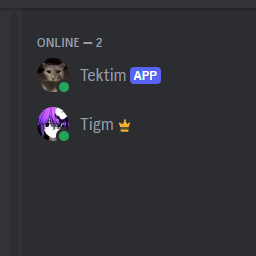

In [15]:
img

In [16]:
preds = imported_model.predict(img_arr)

1/1 [==============================] - 0s 81ms/step


In [18]:
preds

array([[8.6924396e-05, 4.3808496e-01, 5.6182808e-01]], dtype=float32)

In [17]:
print('Predicted class is', class_names[np.argmax(preds)])

Predicted class is neutral
